In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from pprint import pprint
from math import sqrt

#from shutil import unpack_archive
#unpack_archive('./df_input.zip', './')


In [2]:
day_of_week_translator = {
    0: "Domingo",
    1: "Segunda",
    2: "Terca",
    3: "Quarta",
    4: "Quinta",
    5: "Sexta",
    6: "Sabado"
}

feriados = [
            ['Ano Novo', 1, 1],
            ['Carnaval', 24, 2],
            ['Carnaval', 25, 2],
            ['Carnaval', 26, 2],
            ['Dia de São José', 19, 3],
            ['Data Magna', 25, 3],
            ['Sexta-Feira Santa', 10, 4],
            ['Aniversário de Fortaleza', 13, 4],
            ['Tiradentes', 21, 4],
            ['Dia do Trabalho', 1, 5],
            ['Corpus Christi', 28, 5],
            ['N. Senhora da Assunção', 27, 5],
            ['Independência do Brasil', 7, 9],
            ['N. Senhora de Aparecida', 12, 10],
            ['Dia de Finados', 2, 11],
            ['Proclamação da Republica', 15, 11],
            ['Natal', 25, 12],
]

vesperas = [
            ['Ano Novo', 31, 12],
            ['Carnaval', 23, 2],
            ['Dia de São José', 18, 3],
            ['Data Magna', 24, 3],
            ['Sexta-Feira Santa', 9, 4],
            ['Aniversário de Fortaleza', 12, 4],
            ['Tiradentes', 20, 4],
            ['Dia do Trabalho', 30, 4],
            ['N. Senhora da Assunção', 26, 5],
            ['Independência do Brasil', 6, 9],
            ['N. Senhora de Aparecida', 11, 10],
            ['Dia de Finados', 1, 11],
            ['Proclamação da Republica', 14, 11],
            ['Natal', 24, 12],
]

In [3]:
# Reading Data file (geolocalized)
data = pd.read_csv('./df_input.csv', sep=';', delimiter=';')

transformar_features = False
busline_filter = 41
data_model = data.copy()

one_hot_encoder = OneHotEncoder(sparse=False)

data_model[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))
data_model['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]
data_model['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]

encoded_model_data = data_model.loc[data['linha'] == busline_filter].copy()
df_dados_model = encoded_model_data.copy()
display(encoded_model_data)

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
2418,41,2020-03-01 04:00:00,25,6,8.878852e-01,0.460065,4,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2419,41,2020-03-01 05:00:00,168,6,9.790841e-01,0.203456,5,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2420,41,2020-03-01 06:00:00,310,6,9.976688e-01,-0.068242,6,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2421,41,2020-03-01 07:00:00,339,6,9.422609e-01,-0.334880,7,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2422,41,2020-03-01 08:00:00,286,6,8.169699e-01,-0.576680,8,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418148,41,2020-12-31 20:00:00,138,3,-7.308360e-01,0.682553,20,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418149,41,2020-12-31 21:00:00,83,3,-5.195840e-01,0.854419,21,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418150,41,2020-12-31 22:00:00,54,3,-2.697968e-01,0.962917,22,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418151,41,2020-12-31 23:00:00,30,3,-2.449294e-16,1.000000,23,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


In [4]:
feature_names = [
    'hour_sin', 'hour_cos', 
    'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    'feriado', 'vespera_feriado']

target = encoded_model_data['validations_per_hour']

if(transformar_features): 
    scaler = MinMaxScaler(feature_range=(0, 1))

    df_dados_model[feature_names] = scaler.fit_transform(df_dados_model[feature_names])

    df_dados_model
df_dados_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
2418,41,2020-03-01 04:00:00,25,6,8.878852e-01,0.460065,4,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2419,41,2020-03-01 05:00:00,168,6,9.790841e-01,0.203456,5,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2420,41,2020-03-01 06:00:00,310,6,9.976688e-01,-0.068242,6,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2421,41,2020-03-01 07:00:00,339,6,9.422609e-01,-0.334880,7,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2422,41,2020-03-01 08:00:00,286,6,8.169699e-01,-0.576680,8,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418148,41,2020-12-31 20:00:00,138,3,-7.308360e-01,0.682553,20,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418149,41,2020-12-31 21:00:00,83,3,-5.195840e-01,0.854419,21,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418150,41,2020-12-31 22:00:00,54,3,-2.697968e-01,0.962917,22,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418151,41,2020-12-31 23:00:00,30,3,-2.449294e-16,1.000000,23,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


In [5]:
X = df_dados_model.filter(['hour_sin', 'hour_cos', 
    'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    'feriado', 'vespera_feriado'], axis=1)
y = df_dados_model.validations_per_hour
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [6]:
def getModel():
    model = tf.keras.Sequential()
    
    # MLP    
    model.add(tf.keras.layers.Dense(300, activation="relu"))
    model.add(tf.keras.layers.Dense(100, activation="relu"))
    model.add(tf.keras.layers.Dense(30, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="relu"))
    
    # Vanilla LSTM
    # model.add(tf.keras.layers.LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
        
    # Stacked LSTM
    # model.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]) ))
    # model.add(tf.keras.layers.LSTM(75, activation='relu', return_sequences=True))
    # model.add(tf.keras.layers.LSTM(50, activation='relu', return_sequences=True))
    # model.add(tf.keras.layers.LSTM(10, activation='relu'))
    
    # Bidirectional LSTM
#     model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(tf.keras.layers.Dense(units=1,activation='softplus'))
    # model.add(tf.keras.layers.Dense(units=1))

    return model

In [7]:
model = getModel()

optimizer = tf.keras.optimizers.Adam(0.002)

model.compile(
  loss='mse',
  optimizer=optimizer
)
# model.compile(
#   loss='mean_squared_error',
#   optimizer=tf.keras.optimizers.SGD(0.05)
# )

#model.summary()

In [8]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-4, mode='min')]

callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True))

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=48,
    validation_split=0.2,
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/500

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

83/83 [==============================] - 0s 3ms/step - loss: 70700.3594 - val_loss: 67146.3750
Epoch 2/500
83/83 [==============================] - 0s 2ms/step - loss: 63623.6523 - val_loss: 66359.7344
Epoch 3/500
83/83 [==============================] - 0s 2ms/step - loss: 61336.7891 - val_loss: 62527.6602
Epoch 4/500
83/83 [==============================] - 0s 2ms/step 

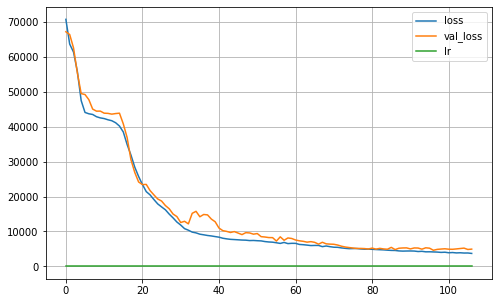

In [9]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [10]:
sample = X_test.sample(n=1)
predict_res = model.predict(sample)

print("Random -> resultado do predict de test: ", predict_res)

Random -> resultado do predict de test:  [[246.42984]]


In [11]:
type(sample)

pandas.core.frame.DataFrame

In [12]:
sample

,hour_sin,hour_cos,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
617208,-0.887885,0.460065,11,193,7,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0


In [33]:
sample = X_test.sample(n=1)
print(len(df_dados_model.loc[sample.index[0]:sample.index[0] + 200]))
display(df_dados_model.loc[sample.index[0]:sample.index[0] + 200])

10


,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
688623,41,2020-07-26 15:00:00,203,6,-8.169699e-01,-0.576680,15,26,208,7,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
688624,41,2020-07-26 16:00:00,227,6,-9.422609e-01,-0.334880,16,26,208,7,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
688625,41,2020-07-26 17:00:00,214,6,-9.976688e-01,-0.068242,17,26,208,7,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
688626,41,2020-07-26 18:00:00,230,6,-9.790841e-01,0.203456,18,26,208,7,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
688627,41,2020-07-26 19:00:00,135,6,-8.878852e-01,0.460065,19,26,208,7,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
688628,41,2020-07-26 20:00:00,152,6,-7.308360e-01,0.682553,20,26,208,7,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
688629,41,2020-07-26 21:00:00,129,6,-5.195840e-01,0.854419,21,26,208,7,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
688630,41,2020-07-26 22:00:00,91,6,-2.697968e-01,0.962917,22,26,208,7,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
688631,41,2020-07-26 23:00:00,44,6,-2.449294e-16,1.000000,23,26,208,7,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
688632,41,2020-07-27 00:00:00,13,0,0.000000e+00,1.000000,0,27,209,7,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [38]:
## Contrucao de exemplo para previsoes
#  'hour_sin', 'hour_cos', 
    # 'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    # 'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    # 'feriado', 'vespera_feriado'
# 24hrs para cada dia para uma determinada linha unica no caso do treinamento
predicts = []
test_cases = [
    ['hour_sin', 'hour_cos', 
    'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    'feriado', 'vespera_feriado'],
    [24, 24, 2, 122, 5, 2,1,0,0,0,0,0,0,0,0], #domingo (2 de maio de 2021)
    [24, 24, 3, 123, 5, 2,0,1,0,0,0,0,0,0,0], #segunda
    [24, 24, 4, 124, 5, 2,0,0,1,0,0,0,0,0,0], #terca
    [24, 24, 5, 125, 5, 2,0,0,0,1,0,0,0,0,0], #quarta
    [24, 24, 6, 126, 5, 2,0,0,0,0,1,0,0,0,0], #quinta
    [24, 24, 7, 127, 5, 2,0,0,0,0,0,1,0,0,0], #sexta
    [24, 24, 8, 128, 5, 2,0,0,0,0,0,0,1,0,0] #sabado
]

column_names = test_cases.pop(0)

test_cases = pd.DataFrame(test_cases, columns=column_names)

if(transformar_features): 
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_cases[feature_names] = scaler.fit_transform(test_cases[feature_names])
display(test_cases)

for index, case in test_cases.iterrows():
    for h in range(0,23):
        case.hour_sin = np.sin(2 * np.pi * h /23.0) #h_sin
        case.hour_cos = np.cos(2 * np.pi * h /23.0) #h_cos
        pred = model.predict(np.array([[case]]))[0][0]
        predicts.append(pred)

#plot predictions
print(predicts)

plt.figure(figsize=(12, 5))
plt.plot(predicts)


ValueError: in user code:

    /anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /anaconda/envs/azureml_py38/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 15 but received input with shape [None, 1]


In [ ]:
type(test_cases)

In [ ]:
# PREVENDO test_size DIAS

# preds = []

# base_teste = np.copy(X_test)

# for i in range(len(base_teste)):
    
#     y_pred = model.predict(np.array([base_teste[i]]))[0][0]

#     preds.append(y_pred)

#     for k in range(len(preds)):
        
#         if k < time_steps:
#             if(i<len(base_teste)-1):
#                 base_teste[i+1][0][(time_steps-1)-k] = preds[(len(preds)-1)-k]

# preds

In [ ]:
base_teste[0].shape

In [ ]:
# APLICANDO O INVERSE SCALING NOS DADOS
if(transformar_features):
    df_dados_model[feature_names] = scaler.inverse_transform(df_dados_model[feature_names])
# dados_predito

In [ ]:
df_real_predito = pd.DataFrame({'real':dados_real,'predito':dados_predito})

df_real_predito

In [ ]:
plt.figure(figsize=(15,5))
# plt.plot(range(len(y_train)),y_train, 'g--')
plt.plot(range(len(df_real_predito['predito'])),df_real_predito['predito'], 'g--')
plt.plot(range(len(df_real_predito['real'])),df_real_predito['real'], 'b')
# plt.xlim(0,200)
# plt.ylim(40,200)
plt.show()

In [ ]:
plt.scatter(df_real_predito['real'],df_real_predito['predito'])

plt.xlabel('Real')
plt.ylabel('Predito')

plt.show()
print('r2=',r2_score(df_real_predito['real'].array,df_real_predito['predito'].array))
print('rmse=',sqrt(mean_squared_error(df_real_predito['real'].array,df_real_predito['predito'].array)))
print('mae=',mean_absolute_error(df_real_predito['real'].array,df_real_predito['predito'].array))